In [14]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
def raytrace(line, extent, pixels, debug=False, display_pixels=False):
    # Fixed issue, alphax[0] in Filip Jacob's paper means first alphax in siddon array, not alphax at zero.

    from math import ceil, floor

    p1x, p1y, p2x, p2y = line
    bx, by, = extent[0], extent[2]
    Nx, Ny = np.size(pixels, 0) + 1, np.size(pixels, 1) + 1
    dx, dy = (extent[1] - extent[0]) / np.size(pixels, 0), (extent[3] - extent[2]) / np.size(pixels, 1)

    p12x = lambda a_: p1x + a_ * (p2x - p1x)
    p12y = lambda a_: p1y + a_ * (p2y - p1y)

    alphax = lambda i_: ((bx + i_ * dx) - p1x) / (p2x - p1x)
    alphay = lambda j_: ((by + j_ * dy) - p1y) / (p2y - p1y)

    if p1x == p2x:
        alphaxmin = 0
        alphaxmax = 0
    else:
        alphaxmin = min(alphax(0), alphax(Nx - 1))
        alphaxmax = max(alphax(0), alphax(Nx - 1))

    if p1y == p2y:
        alphaymin = 0
        alphaymax = 0
    else:
        alphaymin = min(alphay(0), alphay(Ny - 1))
        alphaymax = max(alphay(0), alphay(Ny - 1))


    if p1x == p2x:
        alphamin = max(0, alphaymin)
        alphamax = min(1, alphaymax)
    elif p1y == p2y:
        alphamin = max(0, alphaxmin)
        alphamax = min(1, alphaxmax)
    else:
        alphamin = max(0, alphaxmin, alphaymin)
        alphamax = min(1, alphaxmax, alphaymax)

    phix = lambda a_: (p12x(a_) - bx) / dx

    if p1x < p2x:
        if alphamin == alphaxmin:
            imin = 1
        else:
            imin = ceil(phix(alphamin))

        if alphamax == alphaxmax:
            imax = Nx - 1
        else:
            imax = floor(phix(alphamax))

        if p1x == p2x:
            alphax_ = np.inf
        else:
            alphax_ = alphax(imin)

    else:
        if alphamin == alphaxmin:
            imax = Nx - 2
        else:
            imax = floor(phix(alphamin))

        if alphamax == alphaxmax:
            imin = 0
        else:
            imin = ceil(phix(alphamax))

        if p1x == p2x:
            alphax_ = np.inf
        else:
            alphax_ = alphax(imax)

    phiy = lambda a_: (p12y(a_) - by) / dy

    if p1y < p2y:
        if alphamin == alphaymin:
            jmin = 1
        else:
            jmin = ceil(phiy(alphamin))

        if alphamax == alphaymax:
            jmax = Ny - 1
        else:
            jmax = floor(phiy(alphamax))

        if p1y == p2y:
            alphay_ =  np.inf
        else:
            alphay_ = alphay(jmin)

    else:
        if alphamin == alphaymin:
            jmax = Ny - 2
        else:
            jmax = floor(phiy(alphamin))

        if alphamax == alphaymax:
            jmin = 0
        else:
            jmin = ceil(phiy(alphamax))

        if p1y == p2y:
            alphay_ = np.inf
        else:
            alphay_ = alphay(jmax)

    Np = (imax - imin + 1) + (jmax - jmin + 1)

    alphamid = (min(alphax_, alphay_) + alphamin) / 2

    i = floor(phix(alphamid))
    j = floor(phiy(alphamid))

    if debug:
        draw_alpha(line, alphamin, color='blue')
        draw_alpha(line, alphamax, color='orange')

    if p1x == p2x:
        alphaxu = 0
    else:
        alphaxu = dx / abs(p2x - p1x)
    if p1y == p2y:
        alphayu = 0
    else:
        alphayu = dy / abs(p2y - p1y)

    d12 = 0
    dconv = ((p2x - p1x)**2 + (p2y - p1y)**2)**0.5
    alphac = alphamin

    if debug:
        draw_alpha(line, alphac)

    if p1x < p2x:
        iu = 1
    else:
        iu = -1

    if p1y < p2y:
        ju = 1
    else:
        ju = -1

    for k in range(Np):
        if display_pixels:
            pixels[i, j] = 1

        if alphax_ < alphay_:
            lij = (alphax_ - alphac) * dconv
            d12 = d12 + lij * pixels[i, j]
            i = i + iu
            alphac = alphax_
            alphax_ = alphax_ + alphaxu
        else:
            lij = (alphay_ - alphac) * dconv
            d12 = d12 + lij * pixels[i, j]
            j = j + ju
            alphac = alphay_
            alphay_ = alphay_ + alphayu

        if debug:
            draw_alpha(line, alphac)

    # have to think about this for case of line in and outside of image
    # alphamax == 1 means last point is in image
    # alphamin == 0 means first point is in image
    # print(alphamax, alphamin, alphaxmin, alphaxmax)
    if alphamax == 1:
        if display_pixels:
            pixels[i, j] = 1

        lij = (alphamax - alphac) * dconv
        d12 = d12 + lij * pixels[i, j]

        if debug:
            draw_alpha(line, alphamax)

    if debug:
        draw_algorithm(extent, pixels)
        draw_line(line)

    return d12

In [16]:
%%cython --annotate

cimport cython

from libc.math cimport floor, ceil
from numpy.math cimport INFINITY

cpdef double c_raytrace_fast(double[::1] line, double ex1, double ex2, double ey1, double ey2, double[:, ::1] pixels):
    # Fixed issue, alphax[0] in Filip Jacob's paper means first alphax in siddon array, not alphax at zero.
    cdef:
        double d12 = 0
        double alphaxmin, alphaxmax
        double alphaymin, alphaymax
        double p1x, p1y, p2x, p2y
        double bx, by
        int Nx, Ny
        double dx, dy
        double alphax, alphay
        double alphamid
        int i, j, iu, ju
        int imax, imin, jmax, jmin
        int Np
        
    p1x = line[0]
    p1y = line[1]
    p2x = line[2]
    p2y = line[3]
    bx, by = ex1, ey1
    Nx, Ny = pixels.shape[0] + 1, pixels.shape[1] + 1
    dx, dy = (ex2 - ex1) / pixels.shape[0], (ey2 - ey1) / pixels.shape[1]

    if p1x == p2x:
        alphaxmin = 0
        alphaxmax = 0
    else:
        alphaxmin = min(((bx + 0 * dx) - p1x) / (p2x - p1x),
                        ((bx + (Nx - 1) * dx) - p1x) / (p2x - p1x))
        alphaxmax = max(((bx + 0 * dx) - p1x) / (p2x - p1x),
                        ((bx + (Nx - 1) * dx) - p1x) / (p2x - p1x))

    if p1y == p2y:
        alphaymin = 0
        alphaymax = 0
    else:
        alphaymin = min(((by + 0 * dy) - p1y) / (p2y - p1y),
                        ((by + (Ny - 1) * dy) - p1y) / (p2y - p1y))
        alphaymax = max(((by + 0 * dy) - p1y) / (p2y - p1y),
                        ((by + (Ny - 1) * dy) - p1y) / (p2y - p1y))

    if p1x == p2x:
        alphamin = max(0, alphaymin)
        alphamax = min(1, alphaymax)
    elif p1y == p2y:
        alphamin = max(0, alphaxmin)
        alphamax = min(1, alphaxmax)
    else:
        alphamin = max(0, alphaxmin, alphaymin)
        alphamax = min(1, alphaxmax, alphaymax)

    if p1x < p2x:
        if alphamin == alphaxmin:
            imin = 1
        else:
            imin = <int>ceil(((p1x + alphamin * (p2x - p1x)) - bx) / dx)

        if alphamax == alphaxmax:
            imax = Nx - 1
        else:
            imax = <int>floor(((p1x + alphamax * (p2x - p1x)) - bx) / dx)

        if p1x == p2x:
            alphax = INFINITY
        else:
            alphax = ((bx + imin * dx) - p1x) / (p2x - p1x)

    else:
        if alphamin == alphaxmin:
            imax = Nx - 2
        else:
            imax = <int>floor(((p1x + alphamin * (p2x - p1x)) - bx) / dx)

        if alphamax == alphaxmax:
            imin = 0
        else:
            imin = <int>ceil(((p1x + alphamax * (p2x - p1x)) - bx) / dx)

        if p1x == p2x:
            alphax = INFINITY
        else:
            alphax = ((bx + imax * dx) - p1x) / (p2x - p1x)

    if p1y < p2y:
        if alphamin == alphaymin:
            jmin = 1
        else:
            jmin = <int>ceil(((p1y + alphamin * (p2y - p1y)) - by) / dy)

        if alphamax == alphaymax:
            jmax = Ny - 1
        else:
            jmax = <int>floor(((p1y + alphamax * (p2y - p1y)) - by) / dy)

        if p1y == p2y:
            alphay =  INFINITY
        else:
            alphay = ((by + jmin * dy) - p1y) / (p2y - p1y)

    else:
        if alphamin == alphaymin:
            jmax = Ny - 2
        else:
            jmax = <int>floor(((p1y + alphamin * (p2y - p1y)) - by) / dy)

        if alphamax == alphaymax:
            jmin = 0
        else:
            jmin = <int>ceil(((p1y + alphamax * (p2y - p1y)) - by) / dy)

        if p1y == p2y:
            alphay = INFINITY
        else:
            alphay = ((by + jmax * dy) - p1y) / (p2y - p1y)

    Np = (imax - imin + 1) + (jmax - jmin + 1)

    alphamid = (min(alphax, alphay) + alphamin) / 2

    i = <int>floor(((p1x + alphamid * (p2x - p1x)) - bx) / dx)
    j = <int>floor(((p1y + alphamid * (p2y - p1y)) - by) / dy)

    if p1x == p2x:
        alphaxu = 0
    else:
        alphaxu = dx / abs(p2x - p1x)
    if p1y == p2y:
        alphayu = 0
    else:
        alphayu = dy / abs(p2y - p1y)

    dconv = ((p2x - p1x)**2 + (p2y - p1y)**2)**0.5
    alphac = alphamin

    if p1x < p2x:
        iu = 1
    else:
        iu = -1

    if p1y < p2y:
        ju = 1
    else:
        ju = -1

    for k in range(Np):

        if alphax < alphay:
            lij = (alphax - alphac) * dconv
            d12 = d12 + lij * pixels[i, j]
            i = i + iu
            alphac = alphax
            alphax = alphax + alphaxu
        else:
            lij = (alphay - alphac) * dconv
            d12 = d12 + lij * pixels[i, j]
            j = j + ju
            alphac = alphay
            alphay = alphay + alphayu

    # have to think about this for case of line in and outside of image
    # alphamax == 1 means last point is in image
    # alphamin == 0 means first point is in image
    # print(alphamax, alphamin, alphaxmin, alphaxmax)
    if alphamax == 1:

        lij = (alphamax - alphac) * dconv
        d12 = d12 + lij * pixels[i, j]

    return d12

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef void c_raytrace_fast_bulk(double[:, ::1] lines, double ex1, double ex2, double ey1, double ey2, double[:, ::1] pixels, double[::1] cache):
    cdef:
        int i
    
    for i in range(lines.shape[0]):
        cache[i] = c_raytrace_fast(lines[i], ex1, ex2, ey1, ey2, pixels)

In [17]:
_cache = np.zeros((10000), dtype=np.double)

def raytrace_fast(line, extent, pixels):
    return c_raytrace_fast(line, extent[0], extent[1], extent[2], extent[3], pixels)

def raytrace_bulk_fast(lines, extent, pixels):
    c_raytrace_fast_bulk(lines, extent[0], extent[1], extent[2], extent[3], pixels, _cache)
    return _cache[:np.size(lines, 0)]

In [24]:
def draw_algorithm(extent, pixels, draw_lines=True):

    plt.imshow(pixels.T, extent=extent, origin='lower')

    if draw_lines:
        # vertical lines
        for i in range(np.size(pixels, 0) + 1):
            x = extent[0] + (extent[1] - extent[0]) / np.size(pixels, 0) * i
            plt.plot([x, x], [extent[2], extent[3]], 'g')

        # horizontal lines
        for i in range(np.size(pixels, 1) + 1):
            y = extent[2] + (extent[3] - extent[2]) / np.size(pixels, 1) * i
            plt.plot([extent[0], extent[1]], [y, y], 'g')


def draw_line(line, draw_option='c-'):
    plt.plot([line[0], line[2]], [line[1], line[3]], draw_option, lw=1)


def draw_alpha(line, alpha, color='red'):
    point_x = line[0] + alpha * (line[2] - line[0])
    point_y = line[1] + alpha * (line[3] - line[1])

    plt.scatter(point_x, point_y, color=color)

In [25]:
def test_outside(seed=8675309, nruns=5000, npixels=50, debug=False):
    import random

    def distance(line):
        return ((line[2] - line[0]) ** 2 + (line[3] - line[1]) ** 2) ** 0.5

    def outside_intersection_distance(line, extent):
        x1, y1, x2, y2 = line
        x3, x4, y3, y4 = extent

        def intersection(x1, x2, y1, y2, x3, x4, y3, y4):
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denom != 0:
                t = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
                t /= denom
                u = - ((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3))
                u /= denom

                if 0 <= t <= 1 and 0 <= u <= 1:
                    return [x1 + t * (x2 - x1), y1 + t * (y2 - y1)]

            return None

        top_intersection = intersection(x1, x2, y1, y2, x3, x4, y4, y4)
        bottom_intersection = intersection(x1, x2, y1, y2, x3, x4, y3, y3)
        left_intersection = intersection(x1, x2, y1, y2, x3, x3, y3, y4)
        right_intersection = intersection(x1, x2, y1, y2, x4, x4, y3, y4)

        intersections = [i for i in [top_intersection, bottom_intersection,
                         left_intersection, right_intersection] if i is not None]

        true_line = [intersections[0][0], intersections[0][1],
                     intersections[1][0], intersections[1][1]]

        return distance(true_line)

    image = np.ones((npixels, npixels))
    extent = [-5, 5, -5, 5]

    plt.figure()
    draw_algorithm(extent, image)

    random.seed(seed)

    differences = []

    for i in range(nruns):
        if random.choice([True, False]):
            line = [extent[0] - 1,
                    random.uniform(extent[2], extent[3]),
                    extent[1] + 1,
                    random.uniform(extent[2], extent[3])]
            true_value = outside_intersection_distance(line, extent)
        else:
            line = [random.uniform(extent[0], extent[1]),
                    extent[2] - 1,
                    random.uniform(extent[0], extent[1]),
                    extent[3] + 1]
            true_value = outside_intersection_distance(line, extent)

        d12 = raytrace(line, extent, image, debug)
        difference = abs(d12 - true_value)
        if difference > 1e-12:
            # print(d12, distance(line), abs(d12 - distance(line)))
            draw_line(line, 'r-')
        else:
            draw_line(line)
        differences.append(difference)

    plt.figure()
    plt.hist(differences)
    print()
    
    plt.show()


def test_innoutside(seed=8675309, nruns=5000, npixels=50, debug=False):
    import random

    def distance(line):
        return ((line[2] - line[0]) ** 2 + (line[3] - line[1]) ** 2) ** 0.5

    image = np.ones((npixels, npixels))
    extent = [-5, 5, -5, 5]

    plt.figure()
    draw_algorithm(extent, image)

    random.seed(seed)

    differences = []

    for i in range(nruns):
        inside_pt = [random.uniform(extent[0], extent[1]),
                     random.uniform(extent[2], extent[3])]
        side = random.choice(['left', 'right', 'top', 'bottom'])
        if side == 'left':
            outside_pt = [extent[0]-1, random.uniform(extent[2], extent[3])]
        elif side == 'right':
            outside_pt = [extent[1]+1, random.uniform(extent[2], extent[3])]
        elif side == 'top':
            outside_pt = [random.uniform(extent[0], extent[1]), extent[3]+1]
        elif side == 'bottom':
            outside_pt = [random.uniform(extent[2], extent[3]), extent[2]-1]

        if random.choice([True, False]):
            line = [inside_pt[0], inside_pt[1], outside_pt[0], outside_pt[1]]
        else:
            line = [outside_pt[0], outside_pt[1], inside_pt[0], inside_pt[1]]

        def intersection(x1, x2, y1, y2, x3, x4, y3, y4):
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denom != 0:
                t = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
                t /= denom
                u = - ((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3))
                u /= denom

                if 0 <= t <= 1 and 0 <= u <= 1:
                    return [x1 + t * (x2 - x1), y1 + t * (y2 - y1)]

            return None

        if side == 'left':
            intersect = intersection(line[0], line[2], line[1], line[3],
                                     extent[0], extent[0], extent[2], extent[3])
        elif side == 'right':
            intersect = intersection(line[0], line[2], line[1], line[3],
                                     extent[1], extent[1], extent[2], extent[3])
        elif side == 'top':
            intersect = intersection(line[0], line[2], line[1], line[3],
                                     extent[0], extent[1], extent[3], extent[3])
        elif side == 'bottom':
            intersect = intersection(line[0], line[2], line[1], line[3],
                                     extent[0], extent[1], extent[2], extent[2])

        true_value = distance([inside_pt[0], inside_pt[1], intersect[0], intersect[1]])
        d12 = raytrace(line, extent, image, debug)
        difference = abs(d12 - true_value)
        if difference > 1e-12:
            # print(d12, true_value, difference)
            draw_line(line, 'r-')
        else:
            draw_line(line)
        differences.append(difference)

    plt.figure()
    plt.hist(differences)
    print()
    
    plt.show()


def test_inside(seed=8675309, nruns=5000, npixels=50, debug=False, display_pixels=False):
    import random

    def distance(line):
        return ((line[2] - line[0]) ** 2 + (line[3] - line[1]) ** 2) ** 0.5

    if display_pixels:
        image = np.zeros((npixels, npixels))
    else:
        image = np.ones((npixels, npixels))
    extent = [-5, 5, -5, 5]

    plt.figure()
    draw_algorithm(extent, image)

    random.seed(seed)

    differences = []

    for i in range(nruns):
        line = [random.uniform(extent[0], extent[1]),
                random.uniform(extent[2], extent[3]),
                random.uniform(extent[0], extent[1]),
                random.uniform(extent[2], extent[3])]

        d12 = raytrace(line, extent, image, debug, display_pixels)
        true_value = distance(line)
        difference = abs(d12 - true_value)
        if difference > 1e-12:
            draw_line(line, 'r-')
        else:
            draw_line(line)
        differences.append(difference)

    plt.figure()
    plt.hist(differences)
    print()
    
    plt.show()


def test_special_cases(nruns=100, npixels=50, run_cython=False):
    def distance(line):
        return ((line[2] - line[0]) ** 2 + (line[3] - line[1]) ** 2) ** 0.5

    image = np.ones((npixels, npixels))
    extent = [-5, 5, -5, 5]

    plt.figure()
    draw_algorithm(extent, image)

    def test_line(line, extent, image, true_value):
        if run_cython:
            d12 = raytrace_fast(line, extent, image)
        else:
            d12 = raytrace(line, extent, image)
        difference = abs(d12 - true_value)
        if difference > 1e-12:
            print(d12, true_value, difference)
            draw_line(line, 'r-')
        else:
            draw_line(line)

    # outside lines
    line = [-6.2, -7.1, -5.4, 7.4]
    test_line(line, extent, image, 0)

    line = [-5.4, -7.1, -6.1, 7.4]
    test_line(line, extent, image, 0)

    line = [-5.4, -7.1, 6.1, -7.4]
    test_line(line, extent, image, 0)

    line = [-5.4, -7.4, 6.1, -7.1]
    test_line(line, extent, image, 0)

    line = [6.2, -7.1, 5.4, 7.4]
    test_line(line, extent, image, 0)

    line = [5.4, -7.1, 6.1, 7.4]
    test_line(line, extent, image, 0)

    line = [-5.4, 7.1, 6.1, 7.4]
    test_line(line, extent, image, 0)

    line = [-5.4, 7.4, 6.1, 7.1]
    test_line(line, extent, image, 0)

    # horizontal lines
    line = [-5.4, 2.11, 6.1, 2.11]
    test_line(line, extent, image, 10)

    line = [5.4, -2.11, -6.1, -2.11]
    test_line(line, extent, image, 10)

    # vertical lines
    line = [2.11, 6.1, 2.11, -5.4]
    test_line(line, extent, image, 10)

    line = [-2.11, -6.1, -2.11, 5.4]
    test_line(line, extent, image, 10)

    # horizontal line inside
    line = [-4.4, 1.11, -4.4+3, 1.11]
    test_line(line, extent, image, 3)

    # horizontal line inside / outside
    line = [-6.4, 3.5, -5 + 3, 3.5]
    test_line(line, extent, image, 3)

    # horizontal line outside / inside
    line = [6.4, 3.5, 5-3, 3.5]
    test_line(line, extent, image, 3)

    # vertical line inside
    line = [1.11, -4.4, 1.11, -4.4+3]
    test_line(line, extent, image, 3)

    # vertical line inside / outside
    line = [3.5, -6.4, 3.5, -5 + 3]
    test_line(line, extent, image, 3)

    # vertical line outside / inside
    line = [3.5, 6.4, 3.5, 5-3]
    test_line(line, extent, image, 3)

    # ray within a single pixel
    line = [1.1, 1.1, 1.12, 1.12]
    test_line(line, extent, image, distance(line))

    # ray crosses the origin only
    line = [0.1, 0.1, -0.1, -0.1]
    test_line(line, extent, image, distance(line))
    
    plt.show()


def test_object(nrays=100):
    import pytracer.transmission as transmission
    import pytracer.geometry as geo
    from scripts.assemblies import shielded_assembly

    xs = np.linspace(-11, 11, 200)
    ys = np.linspace(-6, 6, 200)

    assembly = shielded_assembly()
    assembly_flat = geo.flatten(assembly)

    # truth
    mu_image, extent = transmission.absorbance_image(xs, ys, assembly_flat)
    mu_image = mu_image.T

    draw_algorithm(extent, mu_image, draw_lines=False)

    radians = np.array([0.]) #np.linspace(0, np.pi, 100)
    arc_radians = np.linspace(-np.pi / 8, np.pi / 8, nrays)
    start, end = geo.fan_beam_paths(60, arc_radians, radians, extent=False)
    for (s, e) in zip(start[:, 0], end[:, 0]):
        plt.plot([s[0], e[0]], [s[1], e[1]], color='blue', ls='-', lw=0.2)

    d12_values = np.zeros(nrays)
    d12_index = 0

    for (s, e) in zip(start[:, 0], end[:, 0]):
        line = [s[0], s[1], e[0], e[1]]

        d12_values[d12_index] = raytrace(line, extent, mu_image)
        d12_index += 1

    plt.figure()
    plt.plot(arc_radians, d12_values)
    
    plt.show()

In [26]:
def test_speedup(npixels=50, nruns=100, seed=8675309, run_cython=True):
    import cProfile
    import random

    random.seed(seed)

    image = np.ones((npixels, npixels), dtype=np.double)
    extent = [-5, 5, -5, 5]

    lines = np.zeros((nruns, 4), dtype=np.double)

    for i in range(nruns):
        lines[i] = [random.uniform(extent[0], extent[1]),
                    random.uniform(extent[2], extent[3]),
                    random.uniform(extent[0], extent[1]),
                    random.uniform(extent[2], extent[3])]

    integral_python = 0
    integral_cython = 0

    def test_python_raytrace(lines, extent, image):
        integral = 0
        for line in lines:
            integral += raytrace(line, extent, image)
        print(integral)
        print()

    def test_cython_raytrace(lines, extent, image):
        integral = 0.
#         for line in lines:
#             integral += raytrace_fast(line, extent, image)
        integral = np.sum(raytrace_bulk_fast(lines, extent, image))
        print(integral)
        print()

    g = globals()
    l = locals()
    if run_cython:
        cProfile.runctx('test_cython_raytrace(lines, extent, image)', globals=g, locals=l, sort='time')
    else:
        cProfile.runctx('test_python_raytrace(lines, extent, image)', globals=g, locals=l, sort='time')
    # do cython and compare stats, also compare answers

<IPython.core.display.Javascript object>


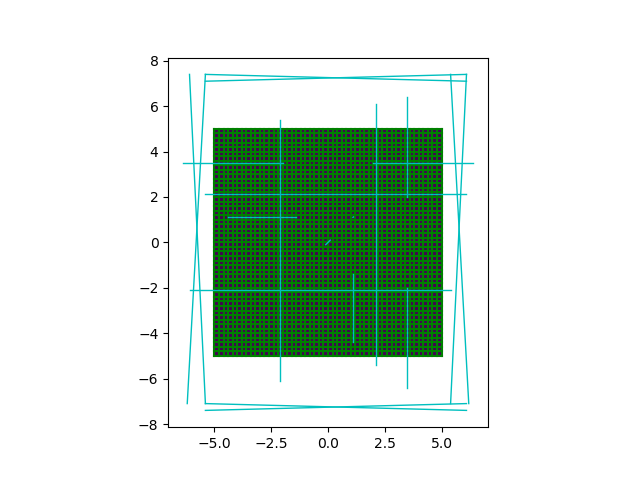

In [27]:
# test_inside(nruns=1, debug=True, display_pixels=True)
# test_outside(nruns=100)
# test_innoutside(nruns=100)
test_special_cases()
# test_object()

# test_speedup(nruns=10000, run_cython=True)
# test_speedup(nruns=10000, run_cython=False)